In [189]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt

In [190]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages, fixing_releases
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages, count(distinct advisory_id, version) as fixing_releases
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by advisories desc;'''
df = pd.DataFrame(sql.execute(q))

In [191]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Maven,1364,1122,688,1940
1,Composer,855,599,228,1733
2,npm,792,474,540,949
3,pip,557,398,261,820
4,NuGet,277,240,66,308
5,Go,235,190,183,325
6,RubyGems,220,167,120,363


,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Maven,1364,1122,688,1940
1,Composer,855,599,228,1733
2,npm,792,474,540,949
3,pip,557,398,261,820
4,NuGet,277,240,66,308
5,Go,235,190,183,325
6,RubyGems,220,167,120,363
7,Total,4300,3190,2086,6438


,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,non-CVEs (%)
0,Maven,1364,1122,688,1940,17.74
1,Composer,855,599,228,1733,29.94
2,npm,792,474,540,949,40.15
3,pip,557,398,261,820,28.55
4,NuGet,277,240,66,308,13.36
5,Go,235,190,183,325,19.15
6,RubyGems,220,167,120,363,24.09


In [192]:
q = '''select ecosystem, ac.cwe as cwe
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe


,cwe
ecosystem,
Composer,68
Go,50
Maven,112
NuGet,29
RubyGems,47
npm,82
pip,83


In [193]:
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[df, cwe])
df.reset_index()
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe
0,Maven,1364,1122,688,1940,112
1,Composer,855,599,228,1733,68
2,npm,792,474,540,949,82
3,pip,557,398,261,820,83
4,NuGet,277,240,66,308,29
5,Go,235,190,183,325,50
6,RubyGems,220,167,120,363,47


In [194]:
df.loc[len(df)]=['Total',df['advisories'].sum(),df['advisory_with_CVEs'].sum(),df['packages'].sum(), df['fixing_releases'].sum(), total_cwes] 
table = df

In [195]:
q = '''select distinct a.id, p.ecosystem, a.severity
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
sev = pd.DataFrame(sql.execute(q))
l, m, h = sev[sev['severity']=='L'],sev[sev['severity']=='M'],sev[sev['severity']=='H']
eco_l = l.groupby('ecosystem')[['severity']].count()
eco_l = eco_l.rename(columns={'severity':'L'})
eco_m = m.groupby('ecosystem')[['severity']].count()
eco_m = eco_m.rename(columns={'severity':'M'})
eco_h = h.groupby('ecosystem')[['severity']].count()
eco_h = eco_h.rename(columns={'severity':'H'})
sf=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[eco_l, eco_m, eco_h])
sf = sf.reset_index()
l,m,h = len(l), len(m), len(h)
sf.loc[len(df)] = ['Total',l,m,h]
sf['T'] = sf.L + sf.M + sf.H
sf['L'] = round(sf['L'] / sf['T'],2)
sf['M'] = round(sf['M'] / sf['T'],2)
sf['H'] = round(sf['H'] / sf['T'],2)
sf['severity'] = sf[['L','M','H']].apply(tuple, axis=1)
sf = sf.drop(['L','M','H','T'], axis=1)
sf

,ecosystem,severity
0,Composer,"(0.04, 0.53, 0.43)"
1,Go,"(0.06, 0.54, 0.4)"
2,Maven,"(0.05, 0.54, 0.41)"
3,NuGet,"(0.02, 0.35, 0.63)"
4,RubyGems,"(0.03, 0.59, 0.38)"
5,npm,"(0.05, 0.47, 0.48)"
6,pip,"(0.06, 0.61, 0.32)"
8,Total,"(0.05, 0.53, 0.43)"


In [196]:
df = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[table, sf])
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity
0,Maven,1364,1122,688,1940,112,"(0.05, 0.54, 0.41)"
1,Composer,855,599,228,1733,68,"(0.04, 0.53, 0.43)"
2,npm,792,474,540,949,82,"(0.05, 0.47, 0.48)"
3,pip,557,398,261,820,83,"(0.06, 0.61, 0.32)"
4,NuGet,277,240,66,308,29,"(0.02, 0.35, 0.63)"
5,Go,235,190,183,325,50,"(0.06, 0.54, 0.4)"
6,RubyGems,220,167,120,363,47,"(0.03, 0.59, 0.38)"
7,Total,4300,3190,2086,6438,171,"(0.05, 0.53, 0.43)"


In [197]:
df['non-CVEs (%)'] = df['advisories'] - df['advisory_with_CVEs']
df['non-CVEs (%)'] = round (df['non-CVEs (%)'] / df['advisories'] * 100 , 2)
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity,non-CVEs (%)
0,Maven,1364,1122,688,1940,112,"(0.05, 0.54, 0.41)",17.74
1,Composer,855,599,228,1733,68,"(0.04, 0.53, 0.43)",29.94
2,npm,792,474,540,949,82,"(0.05, 0.47, 0.48)",40.15
3,pip,557,398,261,820,83,"(0.06, 0.61, 0.32)",28.55
4,NuGet,277,240,66,308,29,"(0.02, 0.35, 0.63)",13.36
5,Go,235,190,183,325,50,"(0.06, 0.54, 0.4)",19.15
6,RubyGems,220,167,120,363,47,"(0.03, 0.59, 0.38)",24.09
7,Total,4300,3190,2086,6438,171,"(0.05, 0.53, 0.43)",25.81


In [198]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrlr}
\hline
 ecosystem   &   advisories &   advisory\_with\_CVEs &   packages &   fixing\_releases &   cwe & severity           &   non-CVEs (\%) \\
\hline
 Maven       &         1364 &                 1122 &        688 &              1940 &   112 & (0.05, 0.54, 0.41) &          17.74 \\
 Composer    &          855 &                  599 &        228 &              1733 &    68 & (0.04, 0.53, 0.43) &          29.94 \\
 npm         &          792 &                  474 &        540 &               949 &    82 & (0.05, 0.47, 0.48) &          40.15 \\
 pip         &          557 &                  398 &        261 &               820 &    83 & (0.06, 0.61, 0.32) &          28.55 \\
 NuGet       &          277 &                  240 &         66 &               308 &    29 & (0.02, 0.35, 0.63) &          13.36 \\
 Go          &          235 &                  190 &        183 &               325 &    50 & (0.06, 0.54, 0.4)  &          19.15 \\
 RubyGems    &          2

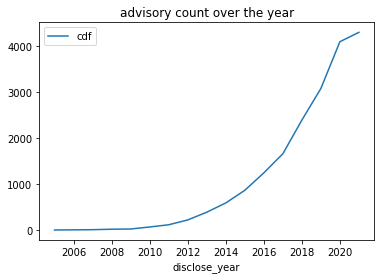

In [199]:
q= '''select year(a.disclose_date) as disclose_year, count(distinct a.id) as count
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by year(a.disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cdf']=df['count'].cumsum()
fig = df.plot(x='disclose_year',y='cdf',kind='line', title = 'advisory count over the year').get_figure()

In [200]:
fig.savefig('cdf_disclose.png')


In [201]:
df

,disclose_year,count,cdf
0,2005,1,1
1,2006,4,5
2,2007,3,8
3,2008,10,18
4,2009,5,23
5,2010,44,67
6,2011,48,115
7,2012,105,220
8,2013,168,388
9,2014,201,589


In [202]:
(4300 - 864) / 4300

0.7990697674418604

In [203]:
4300 - 864

3436